# 1. Normalizing Flows

a. Describe the training objective for flows.

asd

b. Describe the sampling process of normalizing flows.

asd

c. What properties does the transformation function $f_\theta$ must satisfy for practical flow models?

# 2. Wasserstein Distance

In many cases, the GAN algorithm can be though of as minimizing a divergence between a data distribution $p_{data}$ and the model distribution $p_g$. In this problem, we will explore an issue with various divergences (e.g., Jensen-Shannon divergence and KL divergence) and one potential way to fix it.

a. Let $p_{data}~\mathcal{N}(\theta_0,\epsilon^2)$ and $p_g~\mathcal{N}(x|\theta,\epsilon^2)$ be normal distributions with standard deviation $\epsilon$ centered at $\theta_0\in\mathbb{R}$ and $\theta\in\mathbb{R}$, respectively. Show that

$$ D_{KL}(p_g||p_{data})=\frac{(\theta-\theta_0)^2}{2\epsilon^2}. $$

b. Suppose $p_data$ and $p_g$ both place probability mass in only a very small part of the domain; that is, consider the limit $\epsilon\rightarrow0$. What happens to $D_{KL}(p_g||p_{data})$ and its derivative with respect to $\theta$, assuming that $\theta\neq\theta_0$?

c. Would this pose an issue for a GAN trained with the loss function defined below? Why?

$$ L_G(\theta;\phi)=\mathbb{E}_{x~p_\theta(x)}[\log(1-D_\phi(x))]-\mathbb{E}_{x~p_\theta(x)}[\log D_\phi(x)] $$

d. Under the same circumstances as (b), compare KL divergence, JS divergence and Wasserstein Distance.

# 3. Wasserstein GAN for MNIST

In this question, you will train a Wasserstein GAN on the MNIST dataset, which comprises $28\times28$ grayscale images.

a. Implement the optimization process for the Wasserstein GAN. Consider making multiple updates (e.g., 2) to the discriminator for each update to the generator.

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import pickle
import matplotlib.pyplot as plt

In [35]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, pkl='mnist.pkl', phase='train'):
        with open(pkl, 'rb') as f:
            mnist = pickle.load(f)
        self.img = mnist[phase]
        self.img = torch.tensor(self.img).reshape((-1, 1, 28, 28))
        self.label = torch.tensor(mnist[f'{phase}_labels'])

    def __len__(self):
        return self.label.shape[0]
    
    def __getitem__(self, ndx):
        img = (self.img[ndx] / 127.5) - 1
        # img = self.img[ndx] / 255.
        # img = self.img[ndx].float()
        label = self.label[ndx]
        return img, label

In [42]:
class G(nn.Module):
    def __init__(self, batch_size=1, latent_dim=16, device='cpu'):
        super().__init__()
        self.device = device
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 28*28*1), nn.ReLU(),
            nn.Linear(28*28*1, 28*28*2), nn.ReLU(),
            # nn.Linear(28*28*2, 28*28*3), nn.ReLU(),
            # nn.Linear(28*28*3, 28*28*4), nn.ReLU(),
            nn.Linear(28*28*2, 28*28), nn.Tanh(),
        ).to(device)

    def forward(self):
        z = torch.randn((self.batch_size, self.latent_dim)).to(self.device)
        return self.net(z).reshape((-1, 28, 28))

class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 28*28), nn.ReLU(),
            # nn.Linear(28*28*4, 28*28*4), nn.ReLU(),
            # nn.Linear(28*28, 28*28), nn.ReLU(),
            nn.Linear(28*28, 1), nn.Sigmoid(),
        )

    def forward(self, img):
        return self.net(torch.flatten(img, start_dim=1)).squeeze(-1)

class GAN:
    def __init__(self, batch_size=1, device='cpu'):
        # self.batch_size=batch_size
        self.device = device
        self.g = G(batch_size, device=device)
        self.d = D().to(device)
        self.g_optim = torch.optim.Adam(self.g.parameters(), lr=3e-4)
        self.d_optim = torch.optim.Adam(self.d.parameters(), lr=3e-4)
        self.loss_fn = torch.nn.BCELoss()

    def iterate(self, real_img, d_ratio=2):
        # UPDATE G
        for p in self.d.parameters():
            p.requires_grad = False
        for p in self.g.parameters():
            p.requires_grad = True

        self.g_optim.zero_grad()
        fake_img = self.g()
        ones = torch.ones(fake_img.shape[0]).to(self.device)
        fake_lbl_pred = self.d(fake_img)
        g_loss = self.loss_fn(fake_lbl_pred, ones)
        g_loss.backward()
        self.g_optim.step()

        # UPDATE D
        for _ in range(d_ratio):
            for p in self.d.parameters():
                p.requires_grad = True
            for p in self.g.parameters():
                p.requires_grad = False

            self.d_optim.zero_grad()
            zeros = torch.zeros(fake_img.shape[0]).to(self.device)
            fake_lbl_pred = self.d(fake_img.detach())
            d_loss_fake = self.loss_fn(fake_lbl_pred, zeros)

            ones = torch.ones(real_img.shape[0]).to(self.device)
            real_lbl_pred = self.d(real_img)
            d_loss_real = self.loss_fn(real_lbl_pred, ones)

            d_loss = (d_loss_real + d_loss_fake) / 2.
            d_loss.backward()
            self.d_optim.step()

        print(f'g {g_loss:.2f} | d_real {d_loss_real:.2f} | d_fake {d_loss_fake:.2f}', end='\r')


In [43]:
DEVICE='cuda:0'
N_EPOCH = 40
BATCH_SIZE = 128
ds = MNISTDataset()
dl = DataLoader(ds, BATCH_SIZE, shuffle=True)
gan = GAN(batch_size=BATCH_SIZE, device=DEVICE)

In [47]:
for epoch_ndx in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch_ndx:02d}')
    for batch in dl:
        real_img = batch[0].to(DEVICE)
        gan.iterate(real_img)
    print()
    print()

EPOCH 01
g 2.54 | d_real 0.53 | d_fake 0.20

EPOCH 02
g 5.60 | d_real 0.54 | d_fake 0.09

EPOCH 03
g 2.36 | d_real 0.38 | d_fake 0.20

EPOCH 04
g 3.15 | d_real 0.22 | d_fake 0.30

EPOCH 05
g 3.90 | d_real 0.28 | d_fake 0.15

EPOCH 06
g 2.00 | d_real 0.42 | d_fake 0.35

EPOCH 07
g 3.81 | d_real 0.73 | d_fake 0.15

EPOCH 08
g 2.58 | d_real 0.44 | d_fake 0.33

EPOCH 09
g 2.16 | d_real 0.56 | d_fake 0.35

EPOCH 10
g 3.26 | d_real 0.46 | d_fake 0.16

EPOCH 11
g 2.96 | d_real 0.24 | d_fake 0.26

EPOCH 12
g 2.27 | d_real 0.44 | d_fake 0.25

EPOCH 13
g 2.36 | d_real 0.36 | d_fake 0.40

EPOCH 14
g 3.49 | d_real 0.22 | d_fake 0.16

EPOCH 15
g 2.23 | d_real 0.30 | d_fake 0.30

EPOCH 16
g 2.19 | d_real 0.42 | d_fake 0.44

EPOCH 17
g 2.49 | d_real 0.14 | d_fake 0.26

EPOCH 18
g 3.50 | d_real 0.37 | d_fake 0.40

EPOCH 19
g 3.16 | d_real 0.43 | d_fake 0.18

EPOCH 20
g 1.76 | d_real 0.53 | d_fake 0.20

EPOCH 21
g 2.35 | d_real 0.17 | d_fake 0.50

EPOCH 22
g 2.95 | d_real 0.36 | d_fake 0.22

EPOCH 23
g

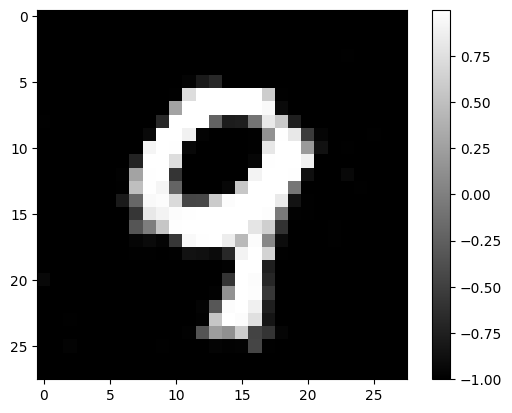

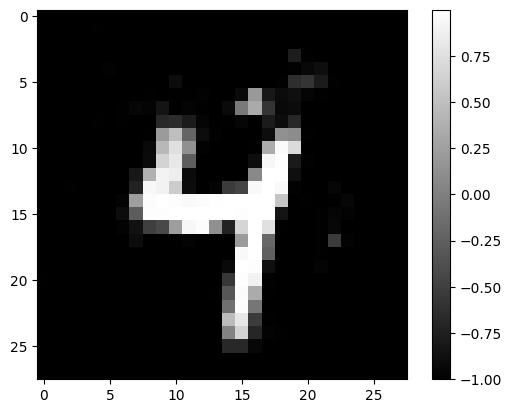

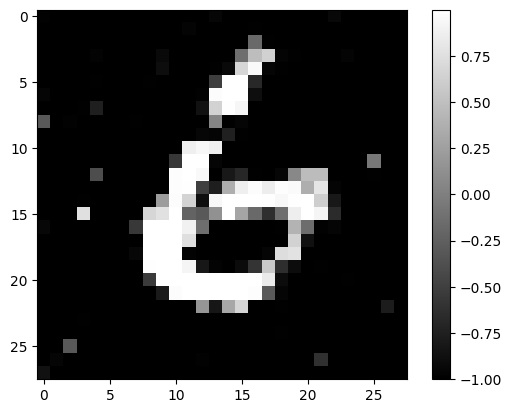

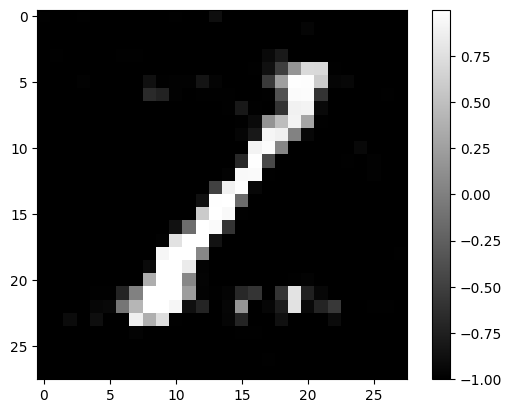

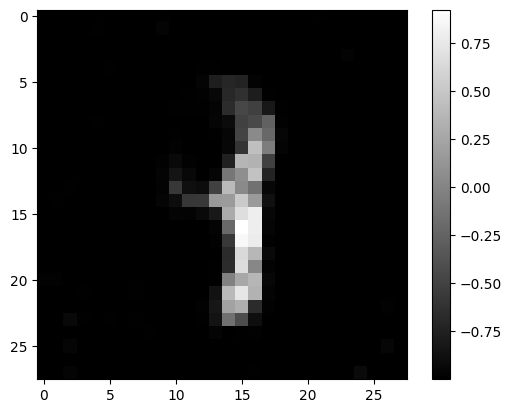

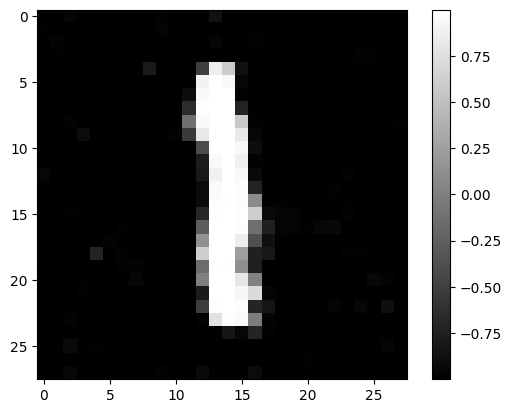

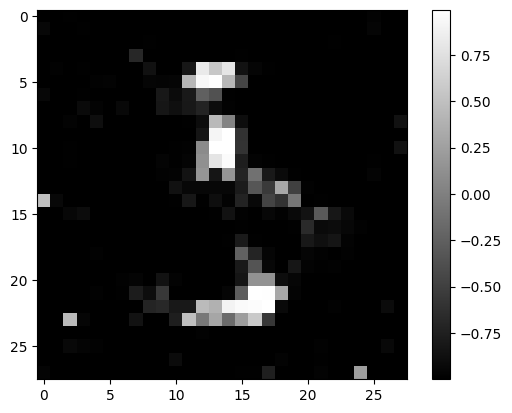

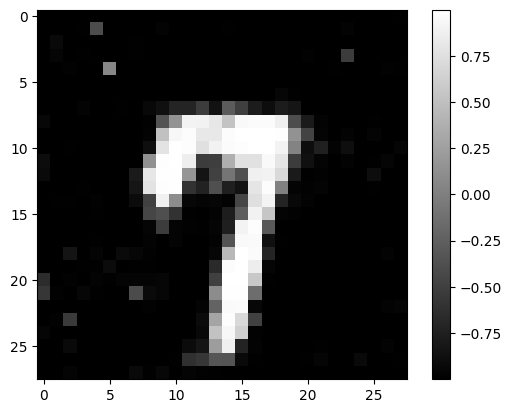

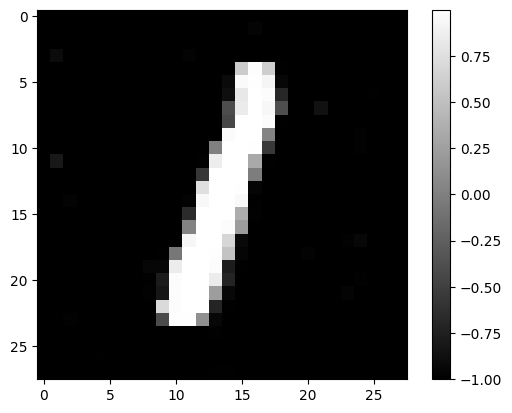

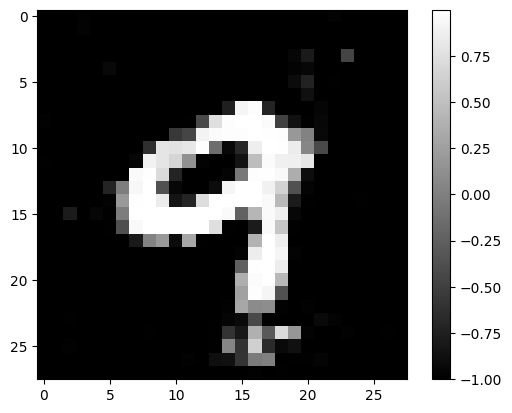

In [48]:
gan.g.eval()
with torch.no_grad():
    fake = gan.g()
for i in range(10):
    im = plt.imshow(fake[i].cpu(), 'gray')
    plt.colorbar(im)
    plt.show()

In [ ]:
g = G()
g.requires_grad_ = False


b. Train your model for 40 epochs (we recommend using a learning rate of lr=3e-4). After training, the generated samples should resemble the results shown below.

## Request deliverables:

a. Provide 100 samples from your trained WGAN.

b. Report the Inception Score (https://github.com/openai/improved-gan/tree/master/inception_score).

c. Include Interpolations between two random latent variables. 
 
